In [2]:
import os
import random
import paddle
import numpy as np
from PIL import Image
import gzip
import json

In [3]:
def load_data(mode='train'):
    datafile = './work/mnist.json.gz'
    data = json.load(gzip.open(datafile))
    print('数据读取完毕！')
    train_set, val_set, eval_set = data
    IMAGES_ROWS = 28
    IMAGES_COLS = 28
    
    if mode == 'train':
        imgs = train_set[0]
        labels = train_set[1]
    elif mode == 'valid':
        imgs = val_set[0]
        labels = val_set[1]
    elif mode == 'eval':
        imgs = eval_set[0]
        labels = eval_set[1]
    else:
        raise Exception("仅支持三种数据！！！")
    assert len(imgs) == len(labels), "数据和标签数量不一致{}!={}".format(len(labels),len(labels))
    index_list = list(range(len(imgs)))
    
    BATCH_SIZE = 100
    
    # 定义数据生成器
    def data_geneator():
        if mode == 'train':
            random.shuffle(index_list)
        imgs_list = []
        labels_list = []
        for i in index_list:
            img = np.reshape(imgs[i],[1,IMAGES_ROWS,IMAGES_COLS]).astype('float32')
            label = np.reshape(labels[i],[1]).astype('int64')
            imgs_list.append(img)
            labels_list.append(label)
            
            if len(imgs_list) == BATCH_SIZE:
                yield np.array(imgs_list),np.array(labels_list)
                imgs_list = []
                labels_list = []
            
        if len(imgs_list)>0:
            yield np.array(imgs_list),np.array(labels_list)
        
    return data_geneator

In [5]:
# 定义模型结构
import paddle.nn.functional as F
from paddle.nn import Conv2D,MaxPool2D, Linear

class MNIST(paddle.nn.Layer):
    def __init__(self):
        super(MNIST,self).__init__()
        self.conv1 = Conv2D(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=2)
        self.max_pool1 = MaxPool2D(kernel_size=2,stride=2)
        self.conv2 = Conv2D(in_channels=20,out_channels=20,kernel_size=5,stride=1,padding=2)
        self.max_pool2= MaxPool2D(kernel_size=2, stride=2)
        self.fc = Linear(in_features=980, out_features=10)
        
    def forward(self, inputs, label=None, check_shape=False, check_content=False):
        outputs1 = self.conv1(inputs)
        outputs2 = F.relu(outputs1)
        outputs3 = self.max_pool1(outputs2)
        outputs4 = self.conv2(outputs3)
        outputs5 = F.relu(outputs4)
        outputs6 = self.max_pool2(outputs5)
        outputs6 = paddle.reshape(outputs6,[outputs6.shape[0],980])
        outputs7 = self.fc(outputs6)
        
        if check_shape:
            # 打印每层网络设置的超参数-卷积核尺寸，卷积步长，卷积padding，池化核尺寸
            print("\n########## print network layer's superparams ##############")
            print("conv1-- kernel_size:{}, padding:{}, stride:{}".format(self.conv1.weight.shape, self.conv1._padding, self.conv1._stride))
            print("conv2-- kernel_size:{}, padding:{}, stride:{}".format(self.conv2.weight.shape, self.conv2._padding, self.conv2._stride))
            #print("max_pool1-- kernel_size:{}, padding:{}, stride:{}".format(self.max_pool1.pool_size, self.max_pool1.pool_stride, self.max_pool1._stride))
            #print("max_pool2-- kernel_size:{}, padding:{}, stride:{}".format(self.max_pool2.weight.shape, self.max_pool2._padding, self.max_pool2._stride))
            print("fc-- weight_size:{}, bias_size_{}".format(self.fc.weight.shape, self.fc.bias.shape))

            # 打印每层的输出尺寸
            print("\n########## print shape of features of every layer ###############")
            print("inputs_shape: {}".format(inputs.shape))
            print("outputs1_shape: {}".format(outputs1.shape))
            print("outputs2_shape: {}".format(outputs2.shape))
            print("outputs3_shape: {}".format(outputs3.shape))
            print("outputs4_shape: {}".format(outputs4.shape))
            print("outputs5_shape: {}".format(outputs5.shape))
            print("outputs6_shape: {}".format(outputs6.shape))
            print("outputs7_shape: {}".format(outputs7.shape))
            # print("outputs8_shape: {}".format(outputs8.shape))
             
        # 选择是否打印训练过程中的参数和输出内容，可用于训练过程中的调试
        if check_content:
            # 打印卷积层的参数-卷积核权重，权重参数较多，此处只打印部分参数
            print("\n########## print convolution layer's kernel ###############")
            print("conv1 params -- kernel weights:", self.conv1.weight[0][0])
            print("conv2 params -- kernel weights:", self.conv2.weight[0][0])

            # 创建随机数，随机打印某一个通道的输出值
            idx1 = np.random.randint(0, outputs1.shape[1])
            idx2 = np.random.randint(0, outputs4.shape[1])
            # 打印卷积-池化后的结果，仅打印batch中第一个图像对应的特征
            print("\nThe {}th channel of conv1 layer: ".format(idx1), outputs1[0][idx1])
            print("The {}th channel of conv2 layer: ".format(idx2), outputs4[0][idx2])
            print("The output of last layer:", outputs7[0], '\n')
            
        
        if label is not None:
            acc = paddle.metric.accuracy(input=outputs7, label=label)
            return outputs7, acc
        else:
            return outputs7

train_loader = load_data('train')
paddle.set_device('gpu:0')

def train(model):
    model = MNIST()
    model.train()
    opt = paddle.optimizer.Adam(learning_rate=0.01,weight_decay=paddle.regularizer.L2Decay(coeff=1e-5),parameters=model.parameters())
    EPOCH_NUMS = 5
    
    iters=[]
    losses=[]
    it_num = 0;
    for epoch_id in range(EPOCH_NUMS):
        for batch_id, data in enumerate(train_loader()):
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            
            #前向计算的过程，同时拿到模型输出值和分类准确率
            if batch_id == 0 and epoch_id==0:
                # 打印模型参数和每层输出的尺寸
                predicts, acc = model(images, labels, check_shape=False, check_content=False)
            elif batch_id==401:
                # 打印模型参数和每层输出的值
                predicts, acc = model(images, labels, check_shape=False, check_content=False)
            else:
                predicts, acc = model(images, labels)
            
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)
            iters.append(it_num+batch_id)
            losses.append(avg_loss)
            
            if batch_id % 200 == 0:
                print("epoch: {},batch: {}, loss is {}, acc is {}".format(epoch_id,batch_id,avg_loss.numpy(),acc.numpy()))
            avg_loss.backward()
            opt.step()
            opt.clear_grad()
        it_num = iters[-1]
    paddle.save(model.state_dict(),'mnist.padparams')
    return iters,losses

model = MNIST()
iters, losses = train(model)

数据读取完毕！
epoch: 0,batch: 0, loss is [2.4322414], acc is [0.11]
epoch: 0,batch: 200, loss is [0.05402344], acc is [0.98]
epoch: 0,batch: 400, loss is [0.02172049], acc is [0.99]
epoch: 1,batch: 0, loss is [0.18258786], acc is [0.95]
epoch: 1,batch: 200, loss is [0.07857169], acc is [0.99]
epoch: 1,batch: 400, loss is [0.08928575], acc is [0.98]
epoch: 2,batch: 0, loss is [0.0389713], acc is [0.99]
epoch: 2,batch: 200, loss is [0.07142266], acc is [0.98]
epoch: 2,batch: 400, loss is [0.20294502], acc is [0.96]
epoch: 3,batch: 0, loss is [0.05296892], acc is [0.98]
epoch: 3,batch: 200, loss is [0.03489161], acc is [0.99]
epoch: 3,batch: 400, loss is [0.00258472], acc is [1.]
epoch: 4,batch: 0, loss is [0.14998242], acc is [0.97]
epoch: 4,batch: 200, loss is [0.01220693], acc is [1.]
epoch: 4,batch: 400, loss is [0.00490483], acc is [1.]


In [24]:
def evaluation(model):
    print('start evaluation')
    params_file_path = 'mnist.padparams'
    param_dict = paddle.load(params_file_path)
    model.load_dict(param_dict)
    model.eval()
    eval_loader = load_data('eval')
    acc_set = []
    avg_loss_set = []
    for batch_id, data in enumerate(eval_loader()):
        images, labels = data
        images = paddle.to_tensor(images)
        labels = paddle.to_tensor(labels)
        predicts, acc = model(images,labels)
        loss = F.cross_entropy(predicts, labels)
        avg_loss = paddle.mean(loss)
        acc_set.append(float(acc.numpy()))
        avg_loss_set.append(float(avg_loss.numpy()))
    acc_val_mean = np.array(acc_set).mean()
    avg_loss_val_mean = np.array(avg_loss_set).mean()
    print('loss is {}, acc is {}'.format(avg_loss_val_mean,acc_val_mean))

model = MNIST()
evaluation(model)

start evaluation
数据读取完毕！
loss is 0.04916936339788663, acc is 0.9865000069141387


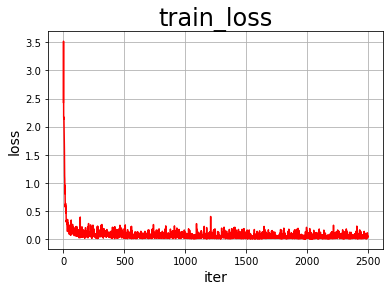

In [9]:
import matplotlib.pyplot as plt
plt.figure()
plt.title("train_loss",fontsize=24)
plt.xlabel("iter",fontsize=14)
plt.ylabel("loss",fontsize=14)
plt.plot(iters,losses,color="red",label="train_loss")
plt.grid()
plt.show()